# Language Visualisations

This notebook produces some visualisations of the language and voting data. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.spatial as sp, scipy.cluster.hierarchy as hc
import plotly.express as px

In [2]:
# load the data sets
df_languages = pd.read_csv('../data/eurovision_languages_categories.csv')
df_merged = pd.read_csv('../data/eurovision_merged_covariates_27Jan.csv')

In [3]:
# load the codes pickle
import pickle
with open('../data/country_codes_dict.pickle', 'rb') as f:
    codes = pickle.load(f)

# replace the to country with the country code
df_languages['Country'] = df_languages['Country'].str.strip().str.lower()
df_languages['To country'] = df_languages['Country'].map(codes)

# remove years NaN and convert year column to an int
df_languages = df_languages.dropna(subset=['Year'])
df_languages['Year'] = df_languages['Year'].astype(int)


In [4]:
df_languages.head()

,Unnamed: 0,Year,Country,Language,Own,English,Other,To country
0,0,1998,croatia,Croatian,1,0,0,HR
1,1,1999,croatia,Croatian,1,0,0,HR
2,2,2000,croatia,Croatian,1,0,0,HR
3,3,2005,croatia,Croatian,1,0,0,HR
4,4,2008,croatia,Croatian,1,0,0,HR


In [5]:
df_merged.head()

,Unnamed: 0,Year,From country,Votes,Country,Own,English,Other,has_border
0,3,1999,AT,0.0,AT,0.0,1.0,0.0,NaN
1,6,1999,AT,12.0,BA,0.0,0.0,1.0,NaN
2,7,1999,AT,0.0,BE,0.0,1.0,0.0,NaN
3,11,1999,AT,0.0,CY,1.0,0.0,0.0,NaN
4,13,1999,AT,10.0,DE,0.0,0.0,1.0,1.0


In [6]:
# merge the two data sets on year and country
df = df_merged.merge(df_languages, left_on=['Year', 'Country'], right_on=['Year', 'To country'], how='left')

In [7]:
# if multiple languages listed, keep them all, or assume first listed is primary and drop the rest
keep_or_drop = 'keep'

df['Language_raw'] = df['Language']

if keep_or_drop == 'keep':
    # if row contains '/' in Language, split it into two rows
    df = df.set_index(df.columns.drop('Language',1).tolist()).Language.str.split('/', expand=True).stack().reset_index().rename(columns={0:'Language'}).loc[:, df.columns]

    # if row contains '(' in Language, split it into two rows
    df = df.set_index(df.columns.drop('Language',1).tolist()).Language.str.split('(', expand=True).stack().reset_index().rename(columns={0:'Language'}).loc[:, df.columns]
else: 
    # drop everything after the first '/, (, partly' in Language
    df['Language'] = df['Language'].str.split('/').str[0]
    df['Language'] = df['Language'].str.split('(').str[0]
    df['Language'] = df['Language'].str.split('partly').str[0]

df['Language'] = df['Language'].str.lower()

# remove 'title ' from Language
df['Language'] = df['Language'].str.replace('title ', '')

# remove brackets from Language
df['Language'] = df['Language'].str.replace(')', '')
df['Language'] = df['Language'].str.replace('(', '')
df['Language'] = df['Language'].str.replace('partly', '')
df['Language'] = df['Language'].str.replace(' and ', ' ')
df['Language'] = df['Language'].str.replace('fr\\.', 'french')
df['Language'] = df['Language'].str.replace('gr\\.', 'greek')
df['Language'] = df['Language'].str.replace('it\\.', 'italian')
df['Language'] = df['Language'].str.replace('sp\\.', 'spanish')
df['Language'] = df['Language'].str.replace('rom\\.', 'romanian')
df['Language'] = df['Language'].str.replace('russ\\.', 'russian')


# trim ws from Language
df['Language'] = df['Language'].str.strip()

# remove NaN
df = df.dropna(subset=['Language'])

df.head()

/var/folders/c2/_b9mpch10xs9cgrc8sq6fhfm0000gr/T/ipykernel_16515/566540675.py:24: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['Language'] = df['Language'].str.replace(')', '')
/var/folders/c2/_b9mpch10xs9cgrc8sq6fhfm0000gr/T/ipykernel_16515/566540675.py:25: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['Language'] = df['Language'].str.replace('(', '')
/var/folders/c2/_b9mpch10xs9cgrc8sq6fhfm0000gr/T/ipykernel_16515/566540675.py:28: FutureWarning: The default value of regex will change from True to False in a future version.
  df['Language'] = df['Language'].str.replace('fr\\.', 'french')
/var/folders/c2/_b9mpch10xs9cgrc8sq6fhfm0000gr/T/ipykernel_16515/566540675.py:29:

,Unnamed: 0_x,Year,From country,Votes,Country_x,Own_x,English_x,Other_x,has_border,Unnamed: 0_y,Country_y,Language,Own_y,English_y,Other_y,To country,Language_raw
0,3,1999,AT,0.0,AT,0.0,1.0,0.0,NaN,308.0,austria,english,0.0,1.0,0.0,AT,English
1,6,1999,AT,12.0,BA,0.0,0.0,1.0,NaN,330.0,bosnia and herzegovina,bosnian,0.0,0.0,1.0,BA,Bosnian/French
2,6,1999,AT,12.0,BA,0.0,0.0,1.0,NaN,330.0,bosnia and herzegovina,french,0.0,0.0,1.0,BA,Bosnian/French
3,7,1999,AT,0.0,BE,0.0,1.0,0.0,NaN,181.0,belgium,english,0.0,1.0,0.0,BE,English
4,11,1999,AT,0.0,CY,1.0,0.0,0.0,NaN,152.0,cyprus,greek,1.0,0.0,0.0,CY,Greek


In [8]:
# print alphabetically sorted unique languages
sorted(df['Language'].unique())

['6 other',
 'albanian',
 'ancient greek',
 'andalusian',
 'arabic',
 'armenian',
 'belarusian',
 'bosnian',
 'bulgarian',
 'corsican',
 'crimean tatar',
 'croatian',
 'danish',
 'english',
 'estonian',
 'finnish',
 'franglais',
 'french',
 'german',
 'greek',
 'hebrew',
 'hungarian',
 'icelandic',
 'imaginary',
 'italian',
 'italo-dalmatian',
 'japanese',
 'latin',
 'lithuanian',
 'maltese',
 'montenegrin',
 'norwegian',
 'polish',
 'portuguese',
 'romani',
 'romanian',
 'russian',
 'sami',
 'samogitian',
 'sanskrit',
 'serbian',
 'sign language',
 'slovene',
 'spanish',
 'styrian german',
 'torlakian dialect',
 'turkish',
 'udmurt',
 'ukrainian']

Now we want to know if voting countries vote more or less favourably for certain languages. We can do this by:

- Option 1. 
    1. calculating the average score for each performance (across all countries). 
    2. calculate the deviation between the average vote and the voting country's vote for that performance. 
    3. Determine the average deviation for each voting country and language. 

- Option 2. 
    1. calculate the average votes for a given language
    2. calculate the average votes for a given language, by a given country
    3. calculate the deviation between the average vote and the voting country's vote for that language. 

---

However, we only calculate the mean in cases where the language is voted on more than three times (n ≥ 3) by the voting country. This is to avoid the problem of outliers skewing the mean. And note that this n may differ between voting countries because a country may itself perform in that language, and will then not be able to vote for that performance. 






In [9]:
option_1 = False

# subset to only the columns we need
languages = df[['Language', 'From country', 'Votes', 'To country', 'Year']].copy()


if option_1:
    # For each year and performing country, add a column for the average votes (i.e. the average votes per performance)
    languages['avg_votes'] = languages.groupby(['To country', 'Year'])['Votes'].transform('mean')

    # For each voting instance calculate the deviation from the average votes
    languages['difference_votes'] = languages['Votes'] - languages['avg_votes']

    # For each From country and Language, add a column for the average difference in votes
    languages['avg_difference_votes'] = languages.groupby(['From country', 'Language'])['difference_votes'].transform('mean')


    # If no_instances < 3, set avg_difference_votes to NaN, since this is not a reflective sample
    languages['no_instances'] = languages.groupby(['From country', 'Language'])['difference_votes'].transform('count')
    languages.loc[languages['no_instances'] < 3, 'avg_difference_votes'] = np.nan

# option 2
else: 
    # The average votes for each language
    languages['avg_votes_per_language'] = languages.groupby(['Language'])['Votes'].transform('mean')

    # The average votes for each language
    languages['avg_votes_per_language_per country'] = languages.groupby(['Language', 'From country'])['Votes'].transform('mean')

    # For each voting instance calculate the deviation from the average votes
    languages['avg_difference_votes'] = languages['avg_votes_per_language_per country'] - languages['avg_votes_per_language']    

    # If no_instances < 3, set avg_difference_votes to NaN, since this is not a reflective sample
    languages['no_instances'] = languages.groupby(['From country', 'Language'])['avg_difference_votes'].transform('count')
    languages.loc[languages['no_instances'] < 3, 'avg_difference_votes'] = np.nan

languages.head()

,Language,From country,Votes,To country,Year,avg_votes_per_language,avg_votes_per_language_per country,avg_difference_votes,no_instances
0,english,AT,0.0,AT,1999,2.422407,2.237500,-0.184907,320
1,bosnian,AT,12.0,BA,1999,2.913386,10.333333,7.419948,3
2,french,AT,12.0,BA,1999,1.429459,1.272727,-0.156731,22
3,english,AT,0.0,BE,1999,2.422407,2.237500,-0.184907,320
4,greek,AT,0.0,CY,1999,2.478261,0.875000,-1.603261,8


In [10]:
languages_heatmap = languages[['From country', 'avg_difference_votes', 'Language']]
languages_heatmap = languages_heatmap.drop_duplicates()

languages_heatmap.head()

,From country,avg_difference_votes,Language
0,AT,-0.184907,english
1,AT,7.419948,bosnian
2,AT,-0.156731,french
4,AT,-1.603261,greek
5,AT,3.393753,german


In [11]:
# convert From country to country name
languages_heatmap['Voting country'] = languages_heatmap['From country'].map({v: k for k, v in codes.items()})
languages_heatmap.head()

,From country,avg_difference_votes,Language,Voting country
0,AT,-0.184907,english,austria
1,AT,7.419948,bosnian,austria
2,AT,-0.156731,french,austria
4,AT,-1.603261,greek,austria
5,AT,3.393753,german,austria


In [12]:
# remove rows where avg_difference_votes is all NaN
languages_heatmap = languages_heatmap.dropna(subset=['avg_difference_votes'])

In [13]:
# increase figure height and width
px.defaults.template = "plotly_white"
px.defaults.width = 900
px.defaults.height = 700

fig = px.density_heatmap(languages_heatmap, x="Language", y="Voting country", z="avg_difference_votes",
                            histfunc="avg", nbinsx=40, nbinsy=40, color_continuous_scale="RdBu_r", range_color=(-10, 10))

fig.update_layout(font_size=8)
fig.show()

In [14]:
# convert long to wide format for heatmap
df_heatmap = languages_heatmap.pivot(index='Voting country', columns='Language', values='avg_difference_votes')

df_heatmap.head()

Language,albanian,arabic,armenian,bosnian,croatian,english,estonian,french,german,greek,...,polish,portuguese,romanian,russian,serbian,sign language,slovene,spanish,turkish,ukrainian
Voting country,,,,,,,,,,,,,,,,,,,,,
albania,-2.065476,-0.123656,-2.711286,1.886614,-1.431034,-0.194993,-2.178862,-0.338550,-1.249104,6.721739,...,NaN,-0.756173,-1.863636,-2.104943,-0.329949,-1.431677,-0.924731,1.218429,4.705650,-2.750000
andorra,NaN,NaN,-3.377953,-2.913386,-1.931034,-0.020538,NaN,3.570541,2.917563,NaN,...,NaN,NaN,0.636364,2.595057,-2.829949,NaN,NaN,6.309734,-2.722922,1.500000
armenia,-2.065476,NaN,-3.377953,-1.663386,-1.264368,-0.054983,NaN,1.360015,-0.749104,4.021739,...,NaN,0.577160,-1.463636,2.295057,-1.615664,-1.265010,-0.924731,0.256793,-1.922922,NaN
australia,NaN,NaN,NaN,NaN,NaN,0.124763,NaN,0.856256,NaN,NaN,...,NaN,0.577160,NaN,NaN,NaN,NaN,NaN,0.209734,NaN,NaN
austria,2.601190,NaN,NaN,7.419948,4.868966,-0.184907,NaN,-0.156731,3.393753,-1.603261,...,1.368217,0.510494,-0.263636,2.095057,4.920051,-0.681677,-0.324731,-0.998962,2.527078,-1.333333


Text(0.5, 1.05, 'Average voting deviation per language')

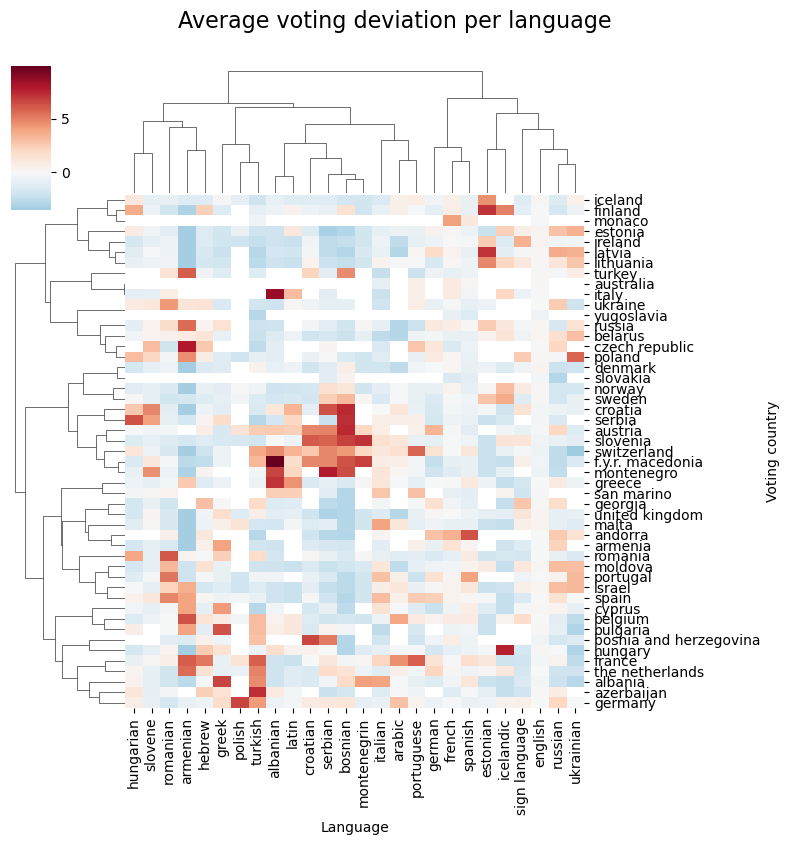

In [15]:
df_heatmap2 = df_heatmap.copy()

row_dism = 1 - df_heatmap2.T.corr()
row_linkage = hc.linkage(sp.distance.squareform(row_dism), method='complete')
col_dism = 1 - df_heatmap2.corr()
col_linkage = hc.linkage(sp.distance.squareform(col_dism), method='complete')


plot = sns.clustermap(df_heatmap2, row_linkage=row_linkage, col_linkage=col_linkage, 
                figsize=(8,8), mask=df_heatmap2.isnull(), 
                cmap='RdBu_r', center=0, xticklabels=1, yticklabels=1)

plot.fig.suptitle('Average voting deviation per language', fontsize=16, y=1.05)


In [16]:
import pandas as pd # library for data analysis
import requests # library to handle requests
from bs4 import BeautifulSoup # library to parse HTML documents

In [19]:
# get the response in the form of html
url="https://en.wikipedia.org/wiki/Languages_of_Europe"


def get_table(table):   

    df=pd.read_html(str(table))
    
    # convert list to dataframe
    df=pd.DataFrame(df[0])

    df.columns =  ['Name', 'ISO', 'Class', 'Native speakers', 'Total speakers', 'National', 'Regional']

    df['Name'] = df['Name'].str.lower()

    return df



In [99]:
response=requests.get(url)

# parse data from the html into a beautifulsoup object
soup = BeautifulSoup(response.text, 'html.parser')

tables=soup.find_all('table',{'class':"wikitable"})
    
table1 = get_table(tables[0])
table2 = get_table(tables[1])


In [100]:
language_class = pd.concat([table1, table2], ignore_index=True)

language_class['short_name'] = language_class['Name'].str.split(' ').str[0]

language_class.head()

,Name,ISO,Class,Native speakers,Total speakers,National,Regional,short_name
0,adyghe,ady,"Northwest Caucasian, Circassian","117,500[30]",NaN,NaN,Adygea (Russia),adyghe
1,albanian (shqip)arbëresharvanitika,sq,Indo-European,"5,367,000[31]5,877,100[32] (Balkans)",NaN,"Albania, Kosovo[nb 3], North Macedonia","Italy, Arbëresh dialect: Sicily, Calabria,[33]...",albanian
2,aragonese,an,"Indo-European, Romance, Western, West Iberian","25,000[34]","55,000[35]",NaN,Aragon (Spain)[nb 4],aragonese
3,aromanian,rup,"Indo-European, Romance, Eastern","114,000[36]",NaN,NaN,North Macedonia (Kruševo),aromanian
4,asturian (astur-leonese),ast,"Indo-European, Romance, Western, West Iberian","351,791[37]","641,502[37]",NaN,Asturias[nb 4],asturian


In [107]:
# subset to languages in df_heatmap

language_class = language_class[language_class['short_name'].isin(df_heatmap.columns)]

language_class.head()

,Name,ISO,Class,Native speakers,Total speakers,National,Regional,short_name,major_class,minor_class
0,albanian (shqip)arbëresharvanitika,sq,Indo-European,"5,367,000[31]5,877,100[32] (Balkans)",NaN,"Albania, Kosovo[nb 3], North Macedonia","Italy, Arbëresh dialect: Sicily, Calabria,[33]...",albanian,Indo-European,NaN
1,bosnian,bs,"Indo-European, Slavic, South, Western, Serbo-C...","2,500,000[43]",NaN,Bosnia and Herzegovina,"Kosovo[nb 3], Montenegro",bosnian,Slavic,Slavic
2,croatian,hr,"Indo-European, Slavic, South, Western, Serbo-C...","5,600,000[54]",NaN,"Bosnia and Herzegovina, Croatia","Burgenland (Austria), Vojvodina (Serbia)",croatian,Slavic,Slavic
3,english,en,"Indo-European, Germanic, West, Anglo-Frisian, ...","63,000,000[59]","260,000,000[60]","Ireland, Malta, United Kingdom",NaN,english,Germanic,Germanic
4,estonian,et,"Uralic, Finno-Ugric, Finnic","1,165,400[62]",NaN,Estonia,NaN,estonian,Finno-Ugric,Finno-Ugric


In [108]:
# get df_heatmap.columns not in df['Name']
missing_languages = df_heatmap.columns[~df_heatmap.columns.isin(language_class['short_name'])]

# for each missing_languages, add a row with NaN values
for language in missing_languages:
    language_class = language_class.append({'Name': language, 'ISO': np.nan, 'Class': np.nan, 'Native speakers': np.nan, 
    'Total speakers': np.nan, 'National': np.nan, 'Regional': np.nan, 'short_name': language}, ignore_index=True)




In [109]:
language_class.tail()

,Name,ISO,Class,Native speakers,Total speakers,National,Regional,short_name,major_class,minor_class
25,greek,el,"Indo-European, Hellenic","Cyprus: 679,883[186]: 2.2 Turkey: 3,600[177]",NaN,Cyprus,NaN,greek,Hellenic,Hellenic
26,russian,ru,"Indo-European, Balto-Slavic, Slavic","Armenia: 15,000[195]Azerbaijan: 250,000[195]Ge...",Armenia: about 0.9 million[196] Azerbaijan: ab...,AbkhaziaSouth Ossetia,Armenia Azerbaijan,russian,Balto-Slavic,Balto-Slavic
27,turkish,tr,"Turkic, Oghuz","Turkey: 66,850,000[177] Cyprus: 1,405[200] + 2...",NaN,Turkey Cyprus Northern Cyprus,NaN,turkish,Oghuz,Oghuz
28,hebrew,NaN,NaN,NaN,NaN,NaN,NaN,hebrew,Semitic,Semitic
29,sign language,NaN,NaN,NaN,NaN,NaN,NaN,sign language,Sign Language,Sign Language


In [150]:
# If class list length is greater than 1, get the second element
language_class['major_class'] = language_class['Class'].str.split(',').str[0].str.strip()
language_class['minor_class'] = language_class['Class'].str.split(',').str[1].str.strip()
language_class['subminor_class'] = language_class['Class'].str.split(',').str[2].str.strip()

# for short_name == 'hebrew' set class to semitic
language_class.loc[language_class['short_name'] == 'hebrew', 'major_class'] = 'Semitic'
language_class.loc[language_class['short_name'] == 'sign language', 'major_class'] = 'Sign Language'
language_class.loc[language_class['short_name'] == 'hebrew', 'minor_class'] = 'Semitic'
language_class.loc[language_class['short_name'] == 'sign language', 'minor_class'] = 'Sign Language'


# if minor_class is  NaN, set major_class to minor_class
language_class.loc[language_class['minor_class'].isnull(), 'minor_class'] = language_class['major_class']
language_class.loc[language_class['subminor_class'].isnull(), 'subminor_class'] = language_class['minor_class']

In [151]:
language_class.tail()

,Name,ISO,Class,Native speakers,Total speakers,National,Regional,short_name,major_class,minor_class,subminor_class
25,greek,el,"Indo-European, Hellenic","Cyprus: 679,883[186]: 2.2 Turkey: 3,600[177]",NaN,Cyprus,NaN,greek,Indo-European,Hellenic,Hellenic
26,russian,ru,"Indo-European, Balto-Slavic, Slavic","Armenia: 15,000[195]Azerbaijan: 250,000[195]Ge...",Armenia: about 0.9 million[196] Azerbaijan: ab...,AbkhaziaSouth Ossetia,Armenia Azerbaijan,russian,Indo-European,Balto-Slavic,Slavic
27,turkish,tr,"Turkic, Oghuz","Turkey: 66,850,000[177] Cyprus: 1,405[200] + 2...",NaN,Turkey Cyprus Northern Cyprus,NaN,turkish,Turkic,Oghuz,Oghuz
28,hebrew,NaN,NaN,NaN,NaN,NaN,NaN,hebrew,Semitic,Semitic,Semitic
29,sign language,NaN,NaN,NaN,NaN,NaN,NaN,sign language,Sign Language,Sign Language,Sign Language


In [152]:
# length unique Class
print("Number of major classes: " + str(len(language_class['major_class'].unique())))
print("Number of minor classes: " + str(len(language_class['minor_class'].unique())))
print("Number of minor classes: " + str(len(language_class['subminor_class'].unique())))

Number of major classes: 6
Number of minor classes: 13
Number of minor classes: 18


In [153]:
# Add row annotation to the seaborn clustermap
plot.ax_row_dendrogram.bar(0, 0, color='#1f77b4', label='Indo-European', linewidth=0)
plot.ax_row_dendrogram.bar(0, 0, color='#ff7f0e', label='Uralic', linewidth=0)
plot.ax_row_dendrogram.bar(0, 0, color='#2ca02c', label='Semitic', linewidth=0)
plot.ax_row_dendrogram.bar(0, 0, color='#d62728', label='Altaic', linewidth=0)


<BarContainer object of 1 artists>

In [154]:
# Get the dimensions of the df_heatmap
nrows, ncols = df_heatmap.shape


In [155]:
df_heatmap.head()

Language,albanian,arabic,armenian,bosnian,croatian,english,estonian,french,german,greek,...,polish,portuguese,romanian,russian,serbian,sign language,slovene,spanish,turkish,ukrainian
Voting country,,,,,,,,,,,,,,,,,,,,,
albania,-2.065476,-0.123656,-2.711286,1.886614,-1.431034,-0.194993,-2.178862,-0.338550,-1.249104,6.721739,...,NaN,-0.756173,-1.863636,-2.104943,-0.329949,-1.431677,-0.924731,1.218429,4.705650,-2.750000
andorra,NaN,NaN,-3.377953,-2.913386,-1.931034,-0.020538,NaN,3.570541,2.917563,NaN,...,NaN,NaN,0.636364,2.595057,-2.829949,NaN,NaN,6.309734,-2.722922,1.500000
armenia,-2.065476,NaN,-3.377953,-1.663386,-1.264368,-0.054983,NaN,1.360015,-0.749104,4.021739,...,NaN,0.577160,-1.463636,2.295057,-1.615664,-1.265010,-0.924731,0.256793,-1.922922,NaN
australia,NaN,NaN,NaN,NaN,NaN,0.124763,NaN,0.856256,NaN,NaN,...,NaN,0.577160,NaN,NaN,NaN,NaN,NaN,0.209734,NaN,NaN
austria,2.601190,NaN,NaN,7.419948,4.868966,-0.184907,NaN,-0.156731,3.393753,-1.603261,...,1.368217,0.510494,-0.263636,2.095057,4.920051,-0.681677,-0.324731,-0.998962,2.527078,-1.333333


In [156]:
df_heatmap2 = df_heatmap.copy()

row_dism = 1 - df_heatmap2.T.corr()
row_linkage = hc.linkage(sp.distance.squareform(row_dism), method='complete')
col_dism = 1 - df_heatmap2.corr()
col_linkage = hc.linkage(sp.distance.squareform(col_dism), method='complete')

In [158]:
import matplotlib.patches as mpatches
import colorcet as cc
palette = sns.color_palette(cc.glasbey, n_colors=18)

def colour_order(column_name):
    # list of unique language classes
    #classes = list(language_class.set_index('short_name')[column_name].to_dict().values())
    classes = list(set(language_class[column_name]))

    # create a dictionary of colours for all unique classes
    #color_dict = dict(zip(classes, sns.color_palette("Set3", len(classes))))
    color_dict = dict(zip(classes, palette))
    #print(color_dict)

    # match the df_heatmap2 column names to the classes
    class_order = [language_class[language_class['short_name'] == x][column_name].values[0] for x in df_heatmap2.columns]

    # match column names df_heatmap2 to color_dict by keys
    col_colors = [color_dict[x] for x in class_order]

    # reorder according to col_linkage
    #col_colors = [col_colors[i] for i in col_linkage['leaves']]

    df_col = pd.DataFrame({'language': color_dict.keys(), 'color': color_dict.values()})   
    legend_TN = [mpatches.Patch(color=c, label=l) for c,l in df_col[['color','language']].drop_duplicates().values]

    return col_colors, legend_TN, class_order

major_col_colors, major_legend_TN, major_class_order = colour_order('major_class')
minor_col_colors, minor_legend_TN, minor_class_order = colour_order('minor_class')
subminor_col_colors, subminor_legend_TN, subminor_class_order = colour_order('subminor_class')

In [177]:
df_heatmap2.head()

Language,albanian,arabic,armenian,bosnian,croatian,english,estonian,french,german,greek,...,polish,portuguese,romanian,russian,serbian,sign language,slovene,spanish,turkish,ukrainian
Voting country,,,,,,,,,,,,,,,,,,,,,
albania,-2.065476,-0.123656,-2.711286,1.886614,-1.431034,-0.194993,-2.178862,-0.338550,-1.249104,6.721739,...,NaN,-0.756173,-1.863636,-2.104943,-0.329949,-1.431677,-0.924731,1.218429,4.705650,-2.750000
andorra,NaN,NaN,-3.377953,-2.913386,-1.931034,-0.020538,NaN,3.570541,2.917563,NaN,...,NaN,NaN,0.636364,2.595057,-2.829949,NaN,NaN,6.309734,-2.722922,1.500000
armenia,-2.065476,NaN,-3.377953,-1.663386,-1.264368,-0.054983,NaN,1.360015,-0.749104,4.021739,...,NaN,0.577160,-1.463636,2.295057,-1.615664,-1.265010,-0.924731,0.256793,-1.922922,NaN
australia,NaN,NaN,NaN,NaN,NaN,0.124763,NaN,0.856256,NaN,NaN,...,NaN,0.577160,NaN,NaN,NaN,NaN,NaN,0.209734,NaN,NaN
austria,2.601190,NaN,NaN,7.419948,4.868966,-0.184907,NaN,-0.156731,3.393753,-1.603261,...,1.368217,0.510494,-0.263636,2.095057,4.920051,-0.681677,-0.324731,-0.998962,2.527078,-1.333333


In [180]:
all_cols = pd.DataFrame({'major': major_col_colors, 'minor': minor_col_colors, 'subminor': subminor_col_colors})



# match all_cols index to df_heatmap2 index
all_cols = all_cols.set_index(df_heatmap2.columns)

# # create a nested list
# all_cols = list(list(minor_class_order), list(major_class_order), list(subminor_class_order))

all_cols.head()
# all_cols

,major,minor,subminor
Language,,,
albanian,"(0.0, 0.6745098039215687, 0.7764705882352941)","(0.00392156862745098, 0.5294117647058824, 0.0)","(0.592156862745098, 1.0, 0.0)"
arabic,"(0.8392156862745098, 0.0, 0.0)","(0.4196078431372549, 0.0, 0.30980392156862746)","(0.7490196078431373, 0.011764705882352941, 0.7..."
armenian,"(0.0, 0.6745098039215687, 0.7764705882352941)","(0.592156862745098, 1.0, 0.0)","(0.4196078431372549, 0.0, 0.30980392156862746)"
bosnian,"(0.0, 0.6745098039215687, 0.7764705882352941)","(0.6313725490196078, 0.4588235294117647, 0.411...","(0.0, 0.33725490196078434, 0.34901960784313724)"
croatian,"(0.0, 0.6745098039215687, 0.7764705882352941)","(0.6313725490196078, 0.4588235294117647, 0.411...","(0.0, 0.33725490196078434, 0.34901960784313724)"


In [231]:
networks = sns.load_dataset("brain_networks", index_col=0, header=[0, 1, 2])

# Label 1
network_labels = networks.columns.get_level_values("network")

print(network_labels)

Index(['1', '1', '2', '2', '3', '3', '4', '4', '5', '5', '6', '6', '6', '6',
       '7', '7', '7', '7', '7', '7', '8', '8', '8', '8', '8', '8', '9', '9',
       '10', '10', '11', '11', '12', '12', '12', '12', '12', '13', '13', '13',
       '13', '13', '13', '14', '14', '15', '15', '16', '16', '16', '16', '16',
       '16', '16', '16', '17', '17', '17', '17', '17', '17', '17'],
      dtype='object', name='network')


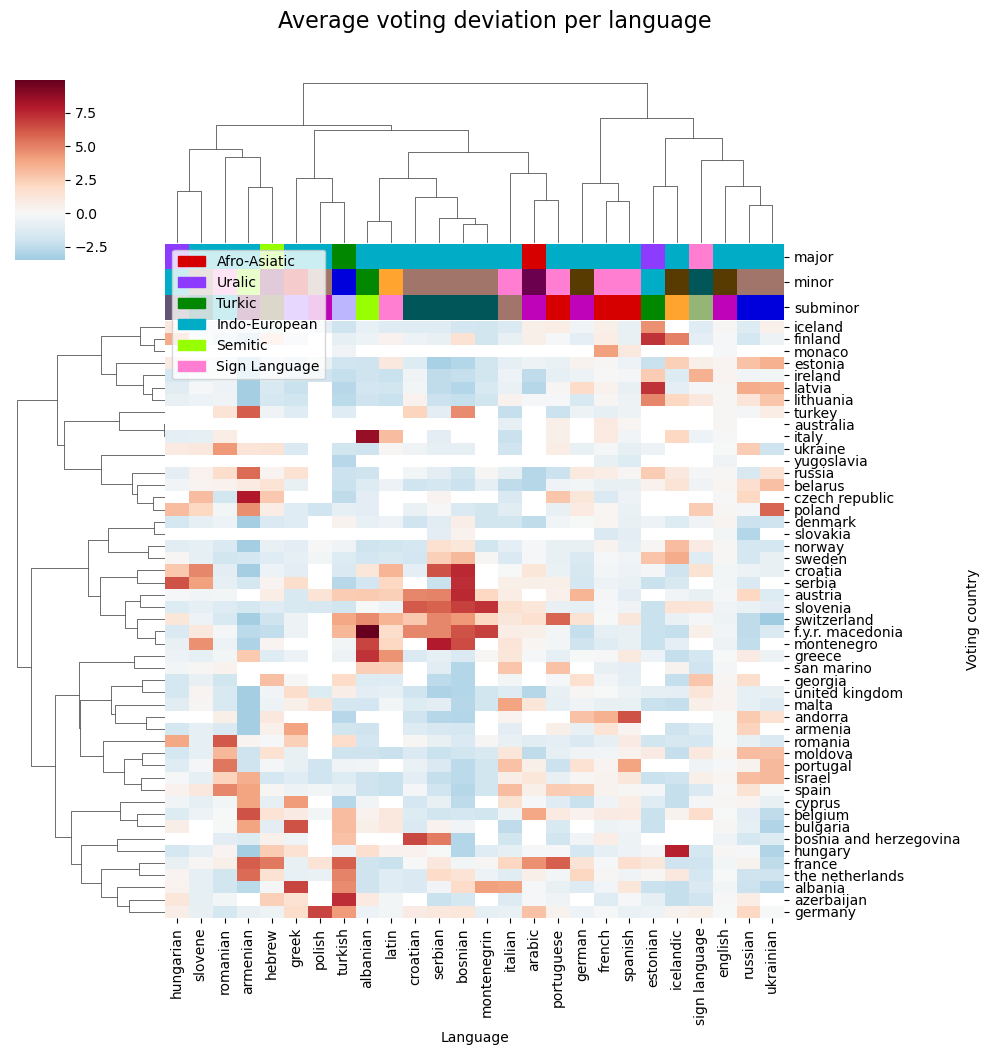

In [240]:

plot = sns.clustermap(df_heatmap2, row_linkage=row_linkage, col_linkage=col_linkage, 
                #figsize=(8,8), mask=df_heatmap2.isnull(), 
                col_colors=all_cols,
                cmap='RdBu_r', 
                center=0, xticklabels=1, yticklabels=1)



plot.fig.suptitle('Average voting deviation per language', fontsize=16, y=1.05)

# l1=plot.ax_heatmap.legend(loc='upper left',bbox_to_anchor=(1.01,0.85),handles=[major_legend_TN, frameon=True)
# l1.set_title(title='Major language class',prop={'size':10})

l1 = plot.ax_heatmap.legend(loc='upper left',bbox_to_anchor=(0.47, 0.89),handles=subminor_legend_TN, frameon=True)
l2 = plot.ax_heatmap.legend(loc='center left',bbox_to_anchor=(1.01,0.85),handles=minor_legend_TN)
l3 = plot.ax_heatmap.legend(loc='lower left',bbox_to_anchor=(0., 0.89),handles=major_legend_TN)


plt.show()

Slavic speaking countries vote for one another? 